In [9]:
from datasets import load_dataset, load_from_disk, Dataset
import random
import matplotlib.pyplot as plt

In [2]:
mscoco = load_dataset("clip-benchmark/wds_mscoco_captions")

Loading dataset shards:   0%|          | 0/27 [00:00<?, ?it/s]

In [3]:
mscoco_train= mscoco['train']

In [4]:
mscoco_train


Dataset({
    features: ['__key__', '__url__', 'jpg', 'txt'],
    num_rows: 82783
})

In [5]:
def extract_first_caption(example):
    example["caption"] = example["txt"].split("\n")[0]
    return example

In [11]:
mscoco_train= mscoco_train.map(extract_first_caption)

Map:   0%|          | 0/82783 [00:00<?, ? examples/s]

In [12]:
mscoco_train[0]

{'__key__': 's0000000',
 '__url__': '/home/gusfysel@GU.GU.SE/.cache/huggingface/hub/datasets--clip-benchmark--wds_mscoco_captions/snapshots/3bf9ad5d280b03126293bcc691585015e29ce691/train/0.tar',
 'jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>,
 'txt': 'Closeup of bins of food that include broccoli and bread.\nA meal is presented in brightly colored plastic trays.\nthere are containers filled with different kinds of foods\nColorful dishes holding meat, vegetables, fruit, and bread.\nA bunch of trays that have different food.',
 'caption': 'Closeup of bins of food that include broccoli and bread.'}

In [13]:
mscoco_train.save_to_disk("image_text_dataset")

Saving the dataset (0/28 shards):   0%|          | 0/82783 [00:00<?, ? examples/s]

In [11]:
mscoco_train = load_from_disk('image_text_dataset')

Loading dataset from disk:   0%|          | 0/28 [00:00<?, ?it/s]

In [13]:
shuffled_dataset = mscoco_train.shuffle(seed=42)
separation_point= len(shuffled_dataset) // 2

In [14]:
def create_matching_pair(example):
    return {"image": example["jpg"], "caption": example["caption"], "label": 1}

In [15]:
matching_pairs = shuffled_dataset.select(range(separation_point)).map(create_matching_pair)

Map:   0%|          | 0/41391 [00:00<?, ? examples/s]

In [16]:
matching_pairs.save_to_disk("matching")

Saving the dataset (0/9 shards):   0%|          | 0/41391 [00:00<?, ? examples/s]

In [19]:
captions = list(mscoco_train["caption"])
random.shuffle(captions)

In [20]:
def create_mismatched_pair(example, index, captions):
    return {"image": example["jpg"], "caption": captions[index], "label": 0}

In [21]:
def mismatched_pair_map(example, idx):
    return create_mismatched_pair(example, idx, captions)

In [23]:
mismatched_pairs = shuffled_dataset.select(range(separation_point, len(shuffled_dataset))).map(
    mismatched_pair_map,
    with_indices=True
)

Map:   0%|          | 0/41392 [00:00<?, ? examples/s]

In [24]:
combined_data = {
        "image": matching_pairs["image"] + mismatched_pairs["image"],
        "caption": matching_pairs["caption"] + mismatched_pairs["caption"],
        "label": matching_pairs["label"] + mismatched_pairs["label"],
    }


In [29]:
image_text_matching_ds = Dataset.from_dict(combined_data)

In [31]:
image_text_matching_ds= image_text_matching_ds.shuffle(seed=42)

In [32]:
image_text_matching_ds.save_to_disk("image_text_dataset")

Saving the dataset (0/9 shards):   0%|          | 0/82783 [00:00<?, ? examples/s]

In [35]:
image_text_matching_ds[2]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x427>,
 'caption': 'A large kitchen with green walls and counters',
 'label': 0}

In [5]:
im_txt_ds = load_from_disk('image_text_dataset')

In [14]:
im_txt_ds[3]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x584>,
 'caption': 'An elephant slakes his thirst by a river as an egret walks behind.',
 'label': 0}

In [15]:
image = im_txt_ds[3]['image']

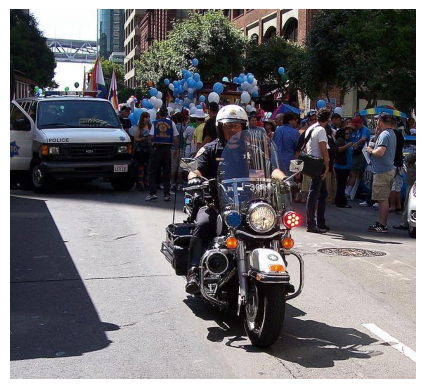

In [16]:
plt.imshow(image)
plt.axis('off') 
plt.show()